# Import& Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import cv2
import random
import math
import os
from PIL import Image
from PIL import ImageDraw
import pandas as pd
from xml.dom import minidom
import csv
from sklearn.model_selection import train_test_split
import torch
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import time
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.patches as patches
import matplotlib.patches as mpatches
%matplotlib inline
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary
%matplotlib inline 

## 本次使用的裝置

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


# 前處理，聚焦於縱膈腔的前處理

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

使用以訓練好的縱膈腔標註模型，取得縱膈腔座標

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2  # 1 class (mediastium) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Chest_Xrays/model_weights2.pth',map_location=torch.device('cpu')))
model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

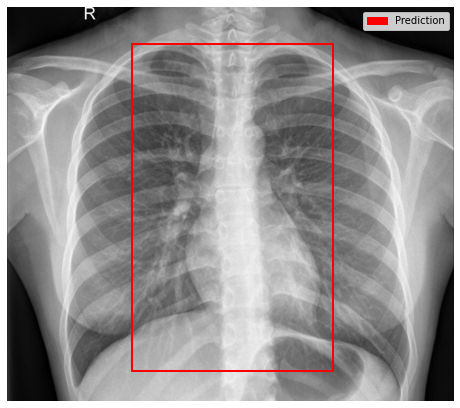

In [ ]:
total_dir="/content/drive/MyDrive/Chest_Xrays/classification/temp/normal/IM-0013-0001.jpeg"
img = Image.open(total_dir).convert('L')
img = train_transforms(img)
img = tuple(img)
images = list(image.to(device) for image in img)
images[0] = images[0].unsqueeze(0)
outputs = model(images)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sample = images[0].permute(1,2,0).cpu().numpy()

boxes_pred = outputs[0]['boxes'].data.cpu().numpy()
box = boxes_pred[0]
rect = patches.Rectangle((box[0], box[1]),box[2]-box[0], box[3]-box[1],
                    linewidth = 2,edgecolor = 'r',facecolor = 'none')
ax.add_patch(rect)
ax.set_axis_off()
red_patch = mpatches.Patch(color='red', label='Prediction')
ax.legend(handles=[red_patch])
ax.imshow(sample.squeeze(), cmap='gray')

In [ ]:
print(box)

[ 542.6477   254.86308 1576.603   2025.268  ]


前處理，包含標註縱膈腔位置裁切出縱膈腔，並且根據長邊Resize成256，再使用padding擴充到256*256的矩形

(1034, 1770)
(149, 256)


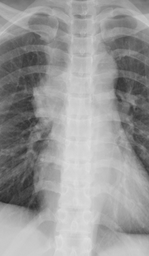

In [ ]:
img = Image.open("/content/drive/MyDrive/縱膈腔/腫瘤/002 00469901 20070704.bmp").convert('L')
img = img.crop((box[0], box[1], box[2], box[3]))
print(img.size)
if img.size[0]>img.size[1]:
  basewidth = 256
  wpercent = (basewidth / float(img.size[0]))
  hsize = int((float(img.size[1]) * float(wpercent)))
  img = img.resize((basewidth, hsize), Image.ANTIALIAS)
else:
  baseheight = 256
  hpercent = (baseheight / float(img.size[1]))
  wsize = int((float(img.size[0]) * float(hpercent)))
  img = img.resize((wsize, baseheight), Image.ANTIALIAS)
print(img.size)
img

padding to square

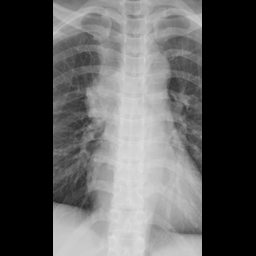

In [ ]:
square = np.zeros((256,256), np.uint8)
square[0:256,53:(256-54)] = img
square = Image.fromarray(square)
square

將所有腫瘤影像全部做以上的處理

In [ ]:
images_DIR = '/content/drive/MyDrive/縱膈腔/腫瘤'
images_files = os.listdir(images_DIR)
i=0
for each in images_files:
  total_dir = os.path.join(images_DIR, each)
  img = Image.open(total_dir).convert('L')
  img_infer = copy.deepcopy(img)
  img_infer = train_transforms(img_infer)
  img_infer = tuple(img_infer)
  images = list(image.to(device) for image in img_infer)
  images[0] = images[0].unsqueeze(0)
  outputs = model(images)
  boxes_pred = outputs[0]['boxes'].data.cpu().numpy()
  box = boxes_pred[0]
  img = img.crop((box[0], box[1], box[2], box[3]))
  square = np.zeros((256,256), np.uint8)
  if img.size[0]>img.size[1]:
    basewidth = 256
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    sub = img.size[0]-img.size[1]
    if sub%2==0:
      square[int(sub/2):int(256-(sub/2)),0:256] = img
    else:
      square[math.floor(sub/2):math.ceiling((256-(sub/2))),0:256] = img
  else:
    baseheight = 256
    hpercent = (baseheight / float(img.size[1]))
    wsize = int((float(img.size[0]) * float(hpercent)))
    img = img.resize((wsize, baseheight), Image.ANTIALIAS)
    sub = img.size[1]-img.size[0]
    if sub%2==0:
      square[0:256,int(sub/2):int(256-(sub/2))] = img
    else:
      square[0:256,int(math.floor(sub/2)):int((256-math.ceil(sub/2)))] = img
  square = Image.fromarray(square)
  # square.save("/content/drive/MyDrive/Chest_Xrays/classification/dataset_focus/tumor/"+str(i)+".png")
  print("save image{}, size: {}".format(i, square.size))
  i+=1

將所有正常影像全部做以上的處理

In [ ]:
images_DIR = '/content/drive/MyDrive/Chest_Xrays/classification/temp/normal'
images_files = os.listdir(images_DIR)
i=0
for each in images_files:
  total_dir = os.path.join(images_DIR, each)
  img = Image.open(total_dir).convert('L')
  img_infer = copy.deepcopy(img)
  img_infer = train_transforms(img_infer)
  img_infer = tuple(img_infer)
  images = list(image.to(device) for image in img_infer)
  images[0] = images[0].unsqueeze(0)
  outputs = model(images)
  boxes_pred = outputs[0]['boxes'].data.cpu().numpy()
  box = boxes_pred[0]
  img = img.crop((box[0], box[1], box[2], box[3]))
  square = np.zeros((256,256), np.uint8)
  if img.size[0]>img.size[1]:
    basewidth = 256
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    sub = img.size[0]-img.size[1]
    if sub%2==0:
      square[int(sub/2):int(256-(sub/2)),0:256] = img
    else:
      square[int(math.floor(sub/2)):int(256-math.ceil((sub/2))),0:256] = img
  else:
    baseheight = 256
    hpercent = (baseheight / float(img.size[1]))
    wsize = int((float(img.size[0]) * float(hpercent)))
    img = img.resize((wsize, baseheight), Image.ANTIALIAS)
    sub = img.size[1]-img.size[0]
    if sub%2==0:
      square[0:256,int(sub/2):int(256-(sub/2))] = img
    else:
      square[0:256,int(math.floor(sub/2)):int((256-math.ceil(sub/2)))] = img
  square = Image.fromarray(square)
  square.save("/content/drive/MyDrive/Chest_Xrays/classification/dataset_focus/normal/"+str(i)+".png")
  print("save image{}, size: {}".format(i, square.size))
  i+=1
  if i==129:
    break

# Normalize images

計算dataset平均與標準差

## 紀錄
focus dataset:
* mean: [0.395538]
* std: [0.31777356]

nonfocus dataset:
* mean:[0.53192285]
* std: [0.23851159]

In [ ]:
#only one channel
mean = np.array([0.])
stdTemp = np.array([0.])
std = np.array([0.])
 

normal_DIR = '/content/drive/MyDrive/Chest_Xrays/classification/dataset_nonfocus/normal'
tumor_DIR = '/content/drive/MyDrive/Chest_Xrays/classification/dataset_nonfocus/tumor'
normal_files = os.listdir(normal_DIR)
tumor_files = os.listdir(tumor_DIR)
total_len  = len(normal_files)+len(tumor_files)

for each in normal_files:
  total_dir = os.path.join(normal_DIR, each)
  im = cv2.imread(total_dir, cv2.IMREAD_GRAYSCALE)
  im = im.astype(float) / 255.
  mean[0] += np.mean(im[:,:])

for each in tumor_files:
  total_dir = os.path.join(tumor_DIR, each)
  im = cv2.imread(total_dir, cv2.IMREAD_GRAYSCALE)
  im = im.astype(float) / 255.
  mean[0] += np.mean(im[:,:])

mean = (mean/total_len)
print(mean) #[0.395538]

for each in normal_files:
  total_dir = os.path.join(normal_DIR, each)
  im = cv2.imread(total_dir, cv2.IMREAD_GRAYSCALE)
  im = im.astype(float) / 255.
  stdTemp[0] += ((im[:,:] - mean[0])**2).sum()/(im.shape[0]*im.shape[1])
for each in tumor_files:
  total_dir = os.path.join(tumor_DIR, each)
  im = cv2.imread(total_dir, cv2.IMREAD_GRAYSCALE)
  im = im.astype(float) / 255.
  stdTemp[0] += ((im[:,:] - mean[0])**2).sum()/(im.shape[0]*im.shape[1])
std = np.sqrt(stdTemp/total_len)

print(std) #[0.31777356]

[0.53192285]
[0.23851159]


## 展示Normalize前後差異

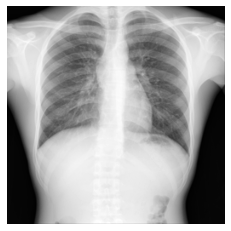

In [ ]:
Normalize = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[mean[0]],
        std=[std[0]],
    ),
])

path="/content/drive/MyDrive/Chest_Xrays/classification/dataset_nonfocus/tumor/10.png"
img = Image.open(path)
ori_img = copy.deepcopy(img)  
plt.axis('off')
plt.imshow(img, cmap='gray')                      
img_nor = Normalize(np.array(img))



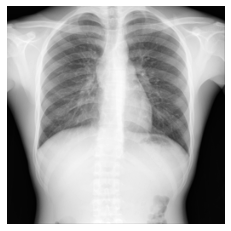

In [ ]:
plt.axis('off')
plt.imshow(np.array(img_nor).squeeze(), cmap='gray')


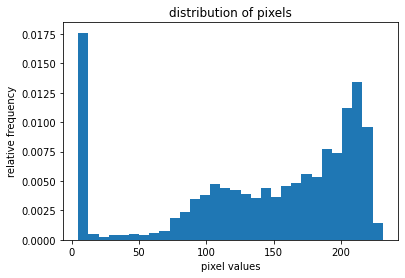

In [ ]:
plt.hist(np.array(ori_img).ravel(), bins=30, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

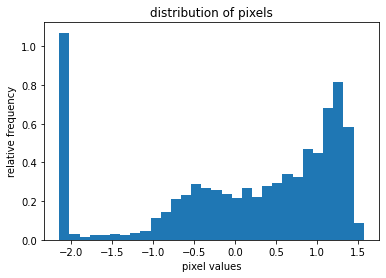

In [ ]:
plt.hist(np.array(img_nor).ravel(), bins=30, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

# 前處理(普通)

一般前處理，裁切掉文字後直接resize

In [ ]:
img = Image.open("/content/drive/MyDrive/Chest_Xrays/classification/normal/NORMAL2-IM-0035-0001.jpeg").convert('L')
print(img.size)
img = img.crop((100, 140, img.size[0], img.size[1])) #L, top, R, Bottom
img = img.resize((256,256))
img

In [ ]:
tumor_DIR = '/content/drive/MyDrive/縱膈腔/腫瘤'
tumor_files = os.listdir(tumor_DIR)
i=0
for img_dir in tumor_files:
  total_dir = os.path.join(tumor_DIR, img_dir)
  img = Image.open(total_dir).convert('L')
  img = img.crop((0, 140, img.size[0], img.size[1])) #L, top, R, Bottom
  img = img.resize((256,256))
  img.save("/content/drive/MyDrive/Chest_Xrays/classification/tumor/"+str(i)+".png")
  i+=1


In [ ]:
normal_DIR = '/content/drive/MyDrive/Chest_Xrays/classification/normal'
normal_files = os.listdir(normal_DIR)
i=0
for img_dir in normal_files:
  total_dir = os.path.join(normal_DIR, img_dir)
  img = Image.open(total_dir).convert('L')
  img = img.crop((0, 140, img.size[0], img.size[1])) #L, top, R, Bottom
  img = img.resize((256,256))
  img.save("/content/drive/MyDrive/Chest_Xrays/classification/normal/"+str(i)+".png")
  i+=1
  if i==128:
    break

# 定義Dataset

In [ ]:

class Dataset(Dataset):
    def __init__(self, data, transform):
        self.images=[]
        self.labels=[]
        self.transform=transform
        for i in data:
          self.images.append(i[0])
          self.labels.append(i[1])
        

    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        label = self.labels[idx]                          
        img = self.transform(img)
        
        return img, label

In [ ]:
dataset=[]
DATA_PATH = "/content/drive/MyDrive/Chest_Xrays/classification/dataset_nonfocus"
for filename in os.listdir(DATA_PATH):
  full_path = os.path.join(DATA_PATH, filename)
  if(filename=='tumor'):
    for imagename in os.listdir(full_path):
      dataset.append([os.path.join(full_path, imagename),1]) #tumor=1
  elif filename=='normal':
    for imagename in os.listdir(full_path):
      dataset.append([os.path.join(full_path, imagename),0]) #normal=0

#convert to nparray
# dataset = np.array(dataset)

參數設定

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[mean],
        std=[std],
    ),
])
SEED = 99
BATCH_SIZE = 16

# training setting
LR = 1e-4

# MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4

切分訓練和測試集

In [ ]:
train, test = train_test_split(dataset, test_size=0.2, random_state=SEED)
train_dataset = Dataset(train, transform)  
test_dataset = Dataset(test, transform)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'There are {len(train_loader)} training batches and {len(test_loader)} testing batches')

There are 13 training batches and 4 testing batches


# 定義模型

In [ ]:

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)
        self.shortcut = nn.Sequential()
        
        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,), resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(filters[4], outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input

# 模型實體化

In [ ]:
# resnet18
resnet18 = ResNet(1, ResBlock, [2, 2, 2, 2], useBottleneck=False, outputs=2)
resnet18.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(resnet18, (1, 256, 256))
resnet18.to(device)
model = resnet18

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,200
         MaxPool2d-2           [-1, 64, 64, 64]               0
       BatchNorm2d-3           [-1, 64, 64, 64]             128
              ReLU-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,928
       BatchNorm2d-6           [-1, 64, 64, 64]             128
            Conv2d-7           [-1, 64, 64, 64]          36,928
       BatchNorm2d-8           [-1, 64, 64, 64]             128
          ResBlock-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,928
      BatchNorm2d-11           [-1, 64, 64, 64]             128
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
         ResBlock-14           [-1, 64,

# 訓練

評量方法、優化器

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay = WEIGHT_DECAY)

In [ ]:
# test_tensor = torch.rand(1,1,256,256)
# out = model(test_tensor)
# for batch_idx, (data_, target_) in enumerate(train_loader):
#   out = model(data_)
#   print(out.shape)
#   print(out)
#   print(target_.shape)
#   break

In [ ]:
num_epochs = 100  #(set no of epochs)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
model.train()
total_step = len(train_loader)
for epoch in range(1,num_epochs+1): #(loop for every epoch)
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        # if (batch_idx) % 20 == 0:
    # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                  #  .format(epoch, num_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (test_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/Chest_Xrays/classification/model/resnet18/100epoch_nonfocus_Norm.pt')
            print('Improvement-Detected, save-model')
    model.train()



Epoch 1



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional_tensor.py:951: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  mean = torch.as_tensor(mean, dtype=dtype, device=tensor.device)



train-loss: 0.2992, train-acc: 88.2927
validation loss: 0.6209, validation acc: 53.8462

Improvement-Detected, save-model
Epoch 2


train-loss: 0.1920, train-acc: 97.5610
validation loss: 0.5834, validation acc: 61.5385

Improvement-Detected, save-model
Epoch 3


train-loss: 0.1747, train-acc: 95.1220
validation loss: 0.4319, validation acc: 96.1538

Improvement-Detected, save-model
Epoch 4


train-loss: 0.1429, train-acc: 98.0488
validation loss: 0.3405, validation acc: 98.0769

Improvement-Detected, save-model
Epoch 5


train-loss: 0.1310, train-acc: 96.5854
validation loss: 0.2844, validation acc: 98.0769

Improvement-Detected, save-model
Epoch 6


train-loss: 0.1121, train-acc: 99.5122
validation loss: 0.2505, validation acc: 98.0769

Epoch 7


train-loss: 0.0970, train-acc: 100.0000
validation loss: 0.2244, validation acc: 98.0769

Epoch 8


train-loss: 0.0859, train-acc: 100.0000
validation loss: 0.2037, validation acc: 98.0769

Improvement-Detected, save-model
Epoch 9


train-l

訓練過程(Accuracy Record)

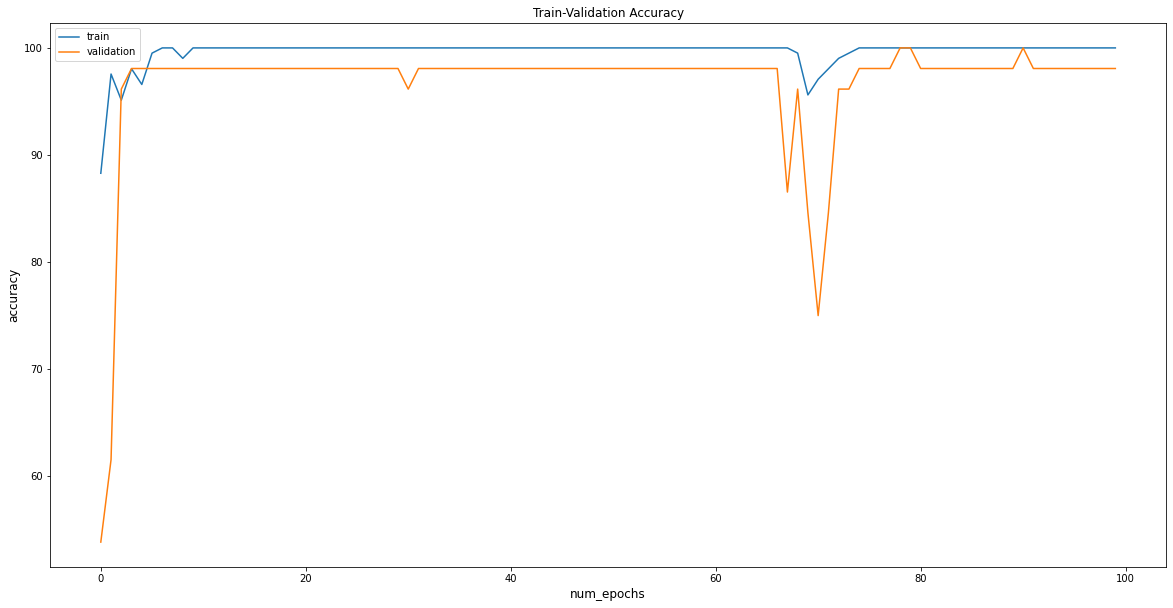

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
fig.savefig("/content/drive/MyDrive/Chest_Xrays/classification/Result/nonfocus/accuracy.png")

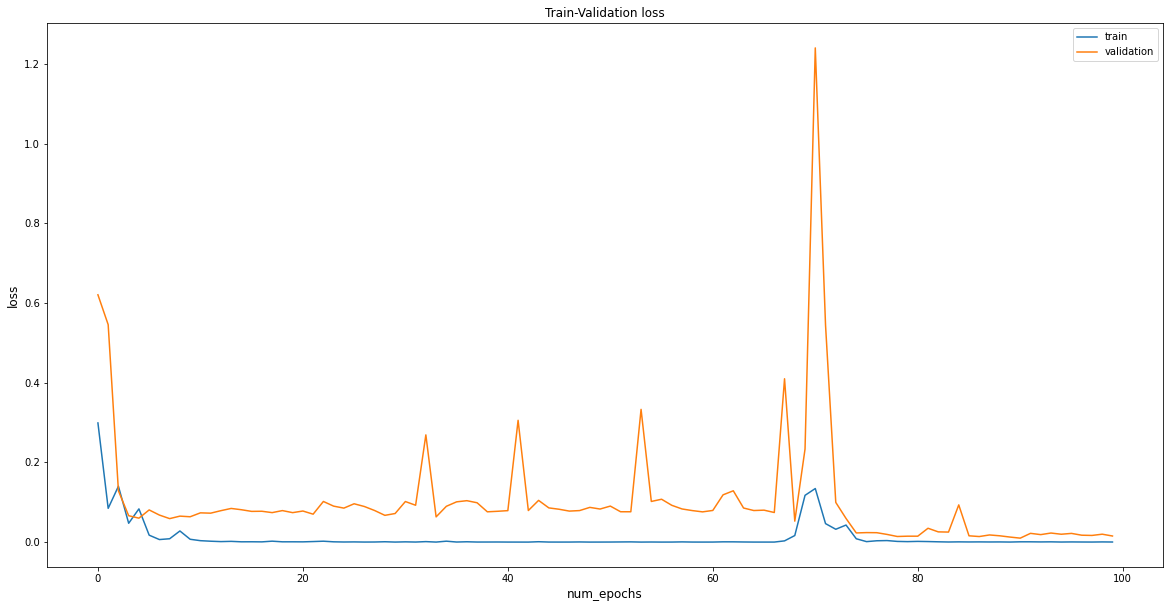

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
fig.savefig("/content/drive/MyDrive/Chest_Xrays/classification/Result/nonfocus/loss.png")

## 視覺化訓練結果

16


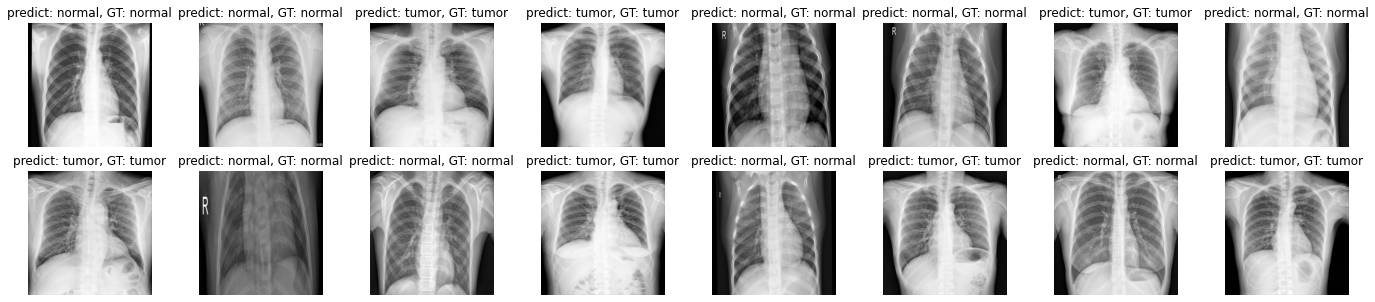

In [ ]:
def visualize_model(net, num_images=4):
    k = 0
    images, labels = next(iter(test_loader))
    print(images.shape[0])
    if device=='cuda:0':
        images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    # print("label: ", labels.shape)
    _, preds = torch.max(outputs.data, 1)
    preds = preds.cpu().numpy() if device=='cuda:0' else preds.numpy()
    fig, ax = plt.subplots(2, 8, figsize=(24, 5))
    for i in range(2):
      for j in range(8):
        ax[i][j].set_axis_off()
        ax[i][j].set_title('predict: {}, GT: {}'.format("tumor" if preds[k]==1 else "normal", "tumor" if labels[k]==1 else "normal"))
        ax[i][j].imshow(images[k].cpu().numpy().squeeze(), cmap='gray')
        k+=1
    fig.savefig("/content/drive/MyDrive/Chest_Xrays/classification/Result/nonfocus/output.png")    


plt.ion()
visualize_model(model)
plt.ioff()

# 載入已訓練好的模型

In [ ]:
model = ResNet(1, ResBlock, [2, 2, 2, 2], useBottleneck=False, outputs=2)
# model.load_state_dict(torch.load('/content/drive/MyDrive/Chest_Xrays/classification/model/resnet18/100epoch_nonfocus_Norm.pt',map_location=torch.device('cpu')))

model.load_state_dict(torch.load('/content/drive/MyDrive/Chest_Xrays/classification/model/resnet18/100epoch_nonfocus_Norm.pt'))
model.to(device)

In [ ]:
tp = .0; tn = .0; fp = .0; fn = .0
with torch.no_grad():
    model.eval()
    for data_t, target_t in (test_loader):
        data_t, target_t = data_t.to(device), target_t.to(device)
        outputs_t = model(data_t)
        _,pred_t = torch.max(outputs_t, dim=1)
        # print(np.array(target_t.cpu()))
        # print(pred_t)
        gt = np.array(target_t.cpu())
        pred_t = np.array(pred_t.cpu())
        for i in range(len(gt)):
          if gt[i]==1 and pred_t[i]==1: 
            tp+=1
          elif gt[i]==0 and pred_t[i]==1:
            fp+=1
          elif gt[i]==0 and pred_t[i]==0:
            tn+=1
          elif gt[i]==1 and pred_t[i]==0:
            fn+=1
    N = tp + fp + tn + fn
    print("total test data number: ",N)
    print("tp: {}, tn: {}, fp: {}, fn: {}".format(tp, tn, fp, fn))
    accuracy = (tp + tn) / (N * 1.0)
    precision = (1.0 * tp) / (tp + fp)
    recall = (1.0 * tp) / (tp + fn)
    f1 = 2.0 / ((1.0 / precision) + (1.0 / recall))
print("Accuracy: {}, Precision: {}, Recall: {}, f1: {}".format(accuracy, precision, recall, f1))

total test data number:  52.0
tp: 25.0, tn: 27.0, fp: 0.0, fn: 0.0
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, f1: 1.0


# 紀錄
100 epoch focus dataset

*   total test data number:  52
*   Accuracy: 0.9038461538461539
*   Precision: 0.8928571428571429,
*   Recall: 0.9259259259259259,
*   f1: 0.9090909090909091


# Grad-CAM

In [ ]:
!pip install grad-cam
!pip uninstall -y enum34
!pip install grad-cam
!pip install ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 19.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.5-py3-none-any.whl size=37027 sha256=abda9c8ab99ccca3552f87a6cf0a7364c00f20a114aa50c784d6e0eb8cc748e3
  Stored in directory: /root/.cache/pip/wheels/f7/c1/fd/59384047f1fab2f99d96b224bdfd0d2b198f896bdb107d66fd
Successfully built grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
images, targ = next(iter(test_loader))
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=images, targets=None)

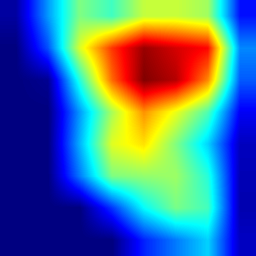

True

In [ ]:
heatmap = cv2.applyColorMap(np.uint8(255*grayscale_cam[0]), cv2.COLORMAP_JET)
cv2_imshow(heatmap)
cv2.imwrite("test_heatmap.png", heatmap)

unNormalize

In [ ]:
x = images[0] * std[:] + mean[:]
x = x.numpy().transpose(1, 2, 0).squeeze()
plt.imshow(x, cmap="gray")

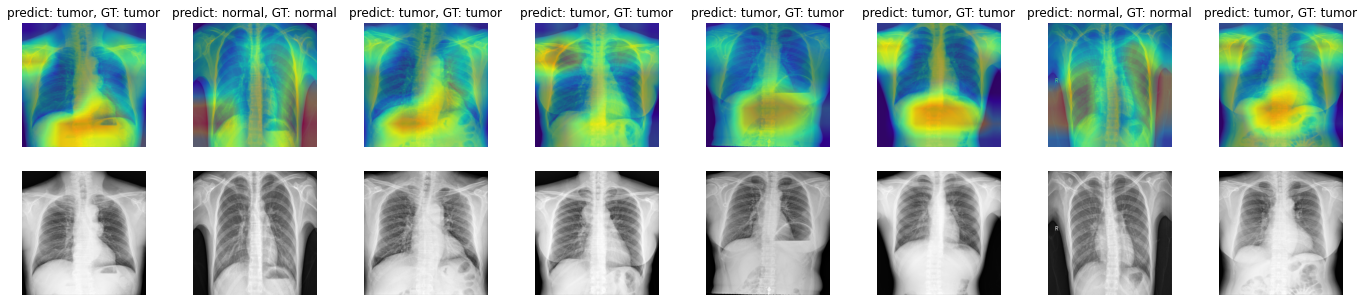

In [ ]:
def visualize_heatmap(net, num_images=4):
    images, labels = next(iter(test_loader))
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=images, targets=None)
    if device=='cuda:0':
        images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    preds = preds.cpu().numpy() if device=='cuda:0' else preds.numpy()
    fig, ax = plt.subplots(2, 8, figsize=(24, 5))
    for j in range(8):
      heatmap = cv2.applyColorMap(np.uint8(255*grayscale_cam[j]), cv2.COLORMAP_JET)
      cv2.imwrite("test_heatmap.png", heatmap)

      # x = images[j] * std[:] + mean[:] #cpu mpde
      x = images[j].cpu() * std[:] + mean[:]
      x = x.numpy().transpose(1, 2, 0).squeeze()
      plt.imsave("test.png", x)
      x=Image.open("test.png").convert("RGB")
      heatmap = Image.open("test_heatmap.png")
      output = Image.blend(x, heatmap, 0.3)
      # plt.imshow(output)
      ax[0][j].set_axis_off()
      ax[0][j].set_title('predict: {}, GT: {}'.format("tumor" if preds[j]==1 else "normal", "tumor" if labels[j]==1 else "normal"))
      ax[0][j].imshow(output)
    for j in range(8):
      ax[1][j].set_axis_off()
      # ax[1][j].set_title('predict: {}, GT: {}'.format("tumor" if preds[k]==1 else "normal", "tumor" if labels[k]==1 else "normal"))
      ax[1][j].imshow(images[j].cpu().numpy().squeeze(), cmap='gray')
    fig.savefig("/content/drive/MyDrive/Chest_Xrays/classification/Result/nonfocus/grad-cam.png")
visualize_heatmap(model)